In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import os
import time
import torch
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

import torch.optim as optim
from torch.optim import lr_scheduler
from copy import deepcopy

In [3]:
from spacetime import SpaceTime
from spacetime.simulate import Simulator
from spacetime.metrics import count_accuracy
from spacetime.models import MLPEncoder, MLPDecoder
from spacetime.training import train, _h_A, _h_A_ordered
from spacetime.utils import arguments, spacetime_mutilator
from spacetime.sampler import NodeData, GraphSampler

simulating a random 3-degree erdos-renyi dag with range (0.5, 2.0) (seed 0)


array([[0.   , 0.   , 0.897, 0.   , 0.   ],
       [0.   , 0.   , 0.   , 1.056, 1.418],
       [0.   , 0.   , 0.   , 0.75 , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 1.156],
       [0.   , 0.   , 0.   , 0.   , 0.   ]])

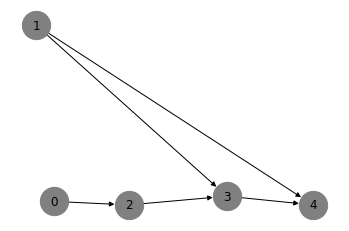

In [4]:
args = arguments(node_dict = {0:[0,1], 1:[2], 2:[3], 3:[4]})
args.data_sample_size=10000
args.noise_scale = 0.6
args.graph_type='erdos-renyi'
args.graph_sem_type='linear-gauss'
args.graph_linear_type='nonlinear_2'
args.graph_degree = 3

# training hyperparameters
args.graph_threshold=0.4  # 0.3 is good 0.2 is error prune
args.tau_A=1e-10
args.ordered_graph=True
args.use_A_connect_loss=False
args.use_A_positiver_loss=False

args.seed=42
args.epochs=5
args.batch_size=100 # note: should be divisible by sample size otherwise throw an error
args.encoder_hidden=64
args.decoder_hidden=64

g = SpaceTime.from_spacelike([0,1,3,2,4], simulate=True,
                             degree=args.graph_degree, graph_type=args.graph_type, 
                             w_range=(0.5,2.0), force_positive=True, seed=0)
g.graph.edges[(1,3)]['weight'] *= 2.0
g.graph.edges[(2,3)]['weight'] *= 0.5
g.show_adj()
g.draw_graph()

In [5]:
col_plot_dict = {0:(4,3), 1:(4,1), 2:(3,2), 3:(2,0)}
mutilate = 3
observe = 4
latent = 1

In [6]:
g.data = Simulator.sem(graph=g.graph, n=args.data_sample_size, x_dims=args.x_dims, 
                       sem_type=args.graph_sem_type, linear_type=args.graph_linear_type, 
                       noise_scale=args.noise_scale, seed=args.seed)
train_loader, test_loader = g.torch_loader(g.data, args.batch_size)

simulating 10000 samples from a linear-gauss sem with nonlinear_2 causal effects


Optimization Finished!
Best Epoch: 0003	 Best ELBO: 0.0411675414 Best NLL: 0.0046660847
Optimization Finished!
Best Epoch: 0004	 Best ELBO: 0.0244643034 Best NLL: 0.0004746710
Optimization Finished!
Best Epoch: 0003	 Best ELBO: 0.0184587567 Best NLL: 0.0004746710
Optimization Finished!
Best Epoch: 0003	 Best ELBO: 0.0164188913 Best NLL: 0.0004539685
Optimization Finished!
Best Epoch: 0002	 Best ELBO: 0.0150791953 Best NLL: 0.0004375540
Optimization Finished!
Best Epoch: 0004	 Best ELBO: 0.0150791953 Best NLL: 0.0002542698
Optimization Finished!
Best Epoch: 0004	 Best ELBO: 0.0129328179 Best NLL: 0.0001233370
Optimization Finished!
Best Epoch: 0004	 Best ELBO: 0.0114347718 Best NLL: 0.0001027340
Optimization Finished!
Best Epoch: 0004	 Best ELBO: 0.0104741815 Best NLL: 0.0000938091
Optimization Finished!
Best Epoch: 0004	 Best ELBO: 0.0097152168 Best NLL: 0.0000827709
Optimization Finished!
Best Epoch: 0004	 Best ELBO: 0.0089202116 Best NLL: 0.0000686460
Optimization Finished!
Best Epoc

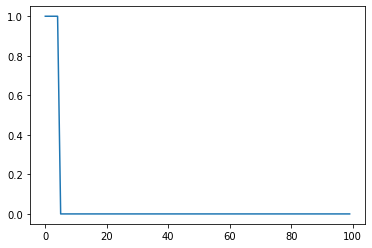

In [7]:
shd_train = []

best_ELBO_loss = np.inf
best_epoch = 0
best_ELBO_graph = None

best_NLL_loss = np.inf
best_NLL_graph = None

# optimizer step on hyparameters
c_A = args.c_A
lambda_A = args.lambda_A
h_A_new = torch.tensor(1.)
h_tol = args.h_tol
k_max_iter = int(args.k_max_iter)
h_A_old = np.inf

#===================================
# load modules
#===================================
# add adjacency matrix A
num_nodes = args.data_variable_size
adj_A = np.zeros((num_nodes, num_nodes))

encoder = MLPEncoder(args.x_dims, args.encoder_hidden, int(args.z_dims), adj_A).double()
decoder = MLPDecoder(args.z_dims, args.x_dims, n_hid=args.decoder_hidden).double()

#===================================
# set up training parameters
#===================================
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()),lr=args.lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=args.lr_decay, gamma=args.gamma)

#===================================
# train model
#===================================
t_total = time.time()
for step_k in range(k_max_iter):
    while c_A < 1e+20:
        for epoch in range(args.epochs):
            ELBO_loss, NLL_loss, graph, origin_A = train(lambda_A, c_A, optimizer, scheduler, 
                                                         encoder, decoder, train_loader, args)
            
            fdr, tpr, fpr, shd, nnz = count_accuracy(g.show_adj(around=10), graph)
            shd_train.append(shd)

            if ELBO_loss < best_ELBO_loss:
                best_ELBO_loss = ELBO_loss
                best_epoch = epoch
                best_ELBO_graph = graph

            if NLL_loss < best_NLL_loss:
                best_NLL_loss = NLL_loss
                best_epoch = epoch
                best_NLL_graph = graph

        print("Optimization Finished!")
        print("Best Epoch: {:04d}\t".format(best_epoch),
              "Best ELBO: {:.10f}".format(best_ELBO_loss),
              "Best NLL: {:.10f}".format(best_NLL_loss))
        if ELBO_loss > 2 * best_ELBO_loss:
            break

        # update parameters
        A_new = origin_A.data.clone()

        if args.ordered_graph:
            h_A_new = _h_A_ordered(A_new, args.node_dict)
        else:
            h_A_new = _h_A(A_new, args.data_variable_size)

        if h_A_new.item() > 0.25 * h_A_old:
            c_A*=10
        else:
            break

        # update parameters
        # h_A, adj_A are computed in loss anyway, so no need to store

    h_A_old = h_A_new.item()
    lambda_A += c_A * h_A_new.item()

    if h_A_new.item() <= h_tol:
        break

# test()
fdr, tpr, fpr, shd, nnz = count_accuracy(g.show_adj(around=10), best_ELBO_graph)

print("Training finished in %s seconds"%(time.time() - t_total))

print('Best ELBO Graph Accuracy: fdr', fdr, ' tpr ', tpr, ' fpr ', fpr, 'shd', shd, 'nnz', nnz)
print(best_ELBO_graph)

print('Ground truth graph')
print(g.show_adj(around=10))

plt.plot(range(len(shd_train)), shd_train)
pass;

## SEM Evaluation

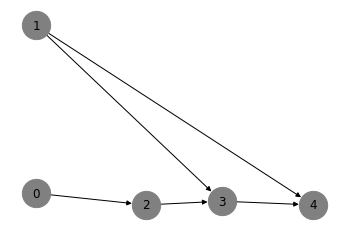

In [8]:
g_learned = SpaceTime.from_adjacency(best_ELBO_graph)
g_learned.draw_graph()

In [9]:
encoder.eval()
decoder.eval()

data = next(iter(test_loader))[0].double()
_, noise, _, _, _, _, Wa_train = encoder(data)
_, preds = decoder(noise, g_learned.torch_graph(), Wa_train)

MLPEncoder(
  (fc1): Linear(in_features=1, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)

MLPDecoder(
  (out_fc1): Linear(in_features=1, out_features=64, bias=True)
  (out_fc3): Linear(in_features=64, out_features=1, bias=True)
)

In [10]:
X_train = NodeData(g.data, bins=10)
Z_learned = NodeData(noise.detach().numpy(), bins=10)
X_learned = NodeData(preds.detach().numpy(), bins=10)

pX_train = GraphSampler(g, X_train)
pZ_learned = GraphSampler(g_learned, Z_learned)
pX_learned = GraphSampler(g_learned, X_learned)

In [11]:
Z_resampled_cdf = NodeData(pZ_learned.resample_from_cdf(size=10000), bins = Z_learned.edges())
Z_resampled_pdf = NodeData(pZ_learned.resample_from_pdf(size=10000), bins = Z_learned.edges())

Fit joint KDE for (0,) in 0.00045490264892578125 seconds
Computed joint distro for (0,) in 0.005078792572021484 seconds
Fit joint KDE for (1,) in 0.0008161067962646484 seconds
Computed joint distro for (1,) in 0.003931522369384766 seconds
Fit conditional KDE for 2 wrt (0,) in 0.0006506443023681641 seconds
Computed conditional distro for 2 wrt (0,) in 0.0792546272277832 seconds
Fit conditional KDE for 3 wrt (1, 2) in 0.0004885196685791016 seconds
Computed conditional distro for 3 wrt (1, 2) in 1.8633458614349365 seconds
Fit conditional KDE for 4 wrt (1, 3) in 0.0006387233734130859 seconds
Computed conditional distro for 4 wrt (1, 3) in 2.259308099746704 seconds
Computed joint distro for (0,) in 0.002363920211791992 seconds
Computed joint distro for (1,) in 0.002595186233520508 seconds
Computed conditional distro for 2 wrt (0,) in 0.07244443893432617 seconds
Computed conditional distro for 3 wrt (1, 2) in 1.6859126091003418 seconds
Computed conditional distro for 4 wrt (1, 3) in 2.014468

In [12]:
pZ_resampled_cdf = GraphSampler(g_learned, Z_resampled_cdf)
pZ_resampled_pdf = GraphSampler(g_learned, Z_resampled_pdf)

In [13]:
_, preds_resampled_cdf = decoder(g_learned.torch_data(Z_resampled_cdf.data()), g_learned.torch_graph(), Wa_train)
_, preds_resampled_pdf = decoder(g_learned.torch_data(Z_resampled_pdf.data()), g_learned.torch_graph(), Wa_train)
X_resampled_cdf = NodeData(preds_resampled_cdf.detach().numpy(), bins=15)
X_resampled_pdf = NodeData(preds_resampled_pdf.detach().numpy(), bins=15)

pX_resampled_cdf = GraphSampler(g_learned, X_resampled_cdf)
pX_resampled_pdf = GraphSampler(g_learned, X_resampled_pdf)

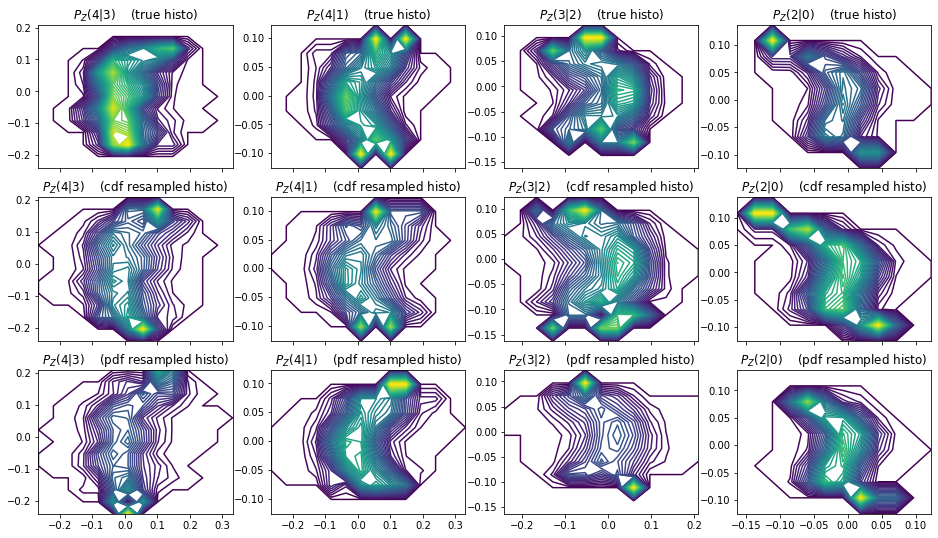

In [14]:
fig, axs = plt.subplots(3, 4, sharex='col', sharey='col', figsize = (16,9))
for col, (d,c) in col_plot_dict.items():
    axs[0][col].set_title(r'$P_Z(%s|%s)$    (true histo)'%(d,c))
    axs[0][col].contour(*pZ_learned.get_contour_conditional(d,c), levels=50)
    axs[1][col].set_title(r'$P_Z(%s|%s)$    (cdf resampled histo)'%(d,c))
    axs[1][col].contour(*pZ_resampled_cdf.get_contour_conditional(d,c), levels=50)
    axs[2][col].set_title(r'$P_Z(%s|%s)$    (pdf resampled histo)'%(d,c))
    axs[2][col].contour(*pZ_resampled_pdf.get_contour_conditional(d,c), levels=50)
pass;

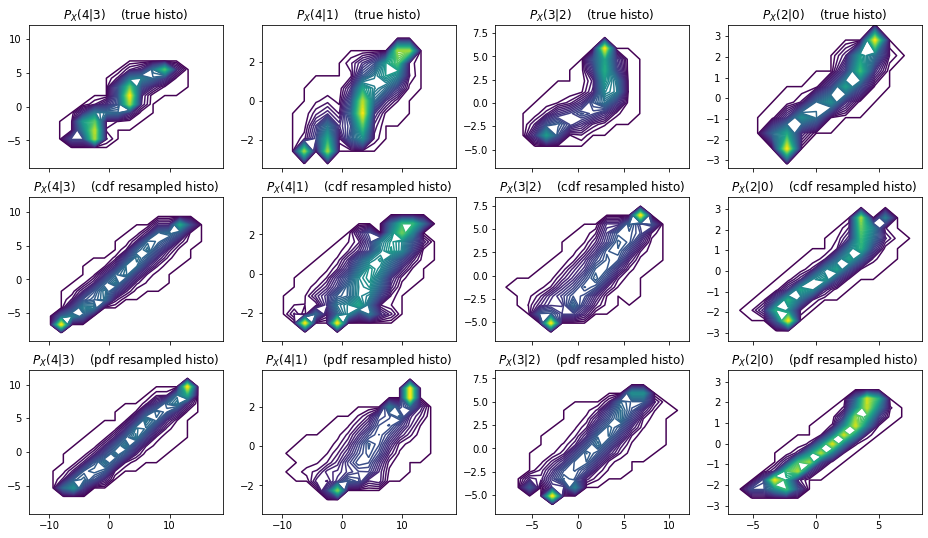

In [15]:
fig, axs = plt.subplots(3, 4, sharex='col', sharey='col', figsize = (16,9))
for col, (d,c) in col_plot_dict.items():
    axs[0][col].set_title(r'$P_X(%s|%s)$    (true histo)'%(d,c))
    axs[0][col].contour(*pX_train.get_contour_conditional(d,c), levels=50)
    axs[1][col].set_title(r'$P_X(%s|%s)$    (cdf resampled histo)'%(d,c))
    axs[1][col].contour(*pX_resampled_cdf.get_contour_conditional(d,c), levels=50)
    axs[2][col].set_title(r'$P_X(%s|%s)$    (pdf resampled histo)'%(d,c))
    axs[2][col].contour(*pX_resampled_pdf.get_contour_conditional(d,c), levels=50)
pass;

In [16]:
# plt.plot(pX_train.node_data.axes(0)[0], pX_train.histogram.compute_joint(0)[1])
# plt.plot(pX_train.node_data.axes(1)[0], pX_train.histogram.compute_joint(1)[1])
# plt.show()
# plt.plot(pX_mutil.node_data.axes(0)[0], pX_mutil.histogram.compute_joint(0)[1])
# plt.plot(pX_mutil.node_data.axes(1)[0], pX_mutil.histogram.compute_joint(1)[1])
# pass;

In [17]:
# truth = pX.histogram.compute_conditional(4,(2,))[1]
# generated = pX_new.histogram.compute_conditional(4,(2,))[1]
# _, truth_ = pX.histogram._epsilonize((), truth)
# _, generated_ = pX.histogram._epsilonize((), generated)
# np.sum(truth_*np.log((truth_/generated_)))/np.prod(truth.shape)

In [18]:
# np.sum(truth)
# np.sum(truth_*np.log((truth_/generated_)), axis=0, keepdims=True)
# np.exp(np.sum(-truth_*np.log((truth_/(truth_*0.1)))))

## Graph Mutilation Tests

In [19]:
g_mutil = spacetime_mutilator(g, mutilate=[mutilate])
g_mutil.data = Simulator.sem(graph=g_mutil.graph, n=10000, x_dims=args.x_dims, 
                             sem_type=args.graph_sem_type, linear_type=args.graph_linear_type, 
                             noise_scale=args.noise_scale, seed=args.seed)

simulating 10000 samples from a linear-gauss sem with nonlinear_2 causal effects


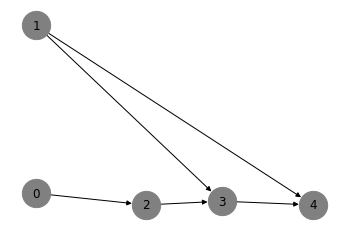

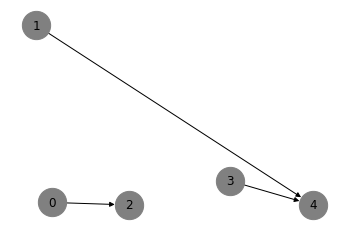

In [20]:
g_learned.draw_graph()

g_learned_mutil = spacetime_mutilator(g_learned, mutilate=[mutilate])
g_learned_mutil.draw_graph()

In [21]:
X_mutil = NodeData(g_mutil.data, bins=10)
pX_mutil = GraphSampler(g, X_mutil)

In [22]:
Z_resampled_mutil_cdf = NodeData(pZ_learned.resample_from_cdf(size=10000, mutilate=[mutilate]), bins = Z_learned.edges())
Z_resampled_mutil_pdf = NodeData(pZ_learned.resample_from_pdf(size=10000, mutilate=[mutilate]), bins = Z_learned.edges())
pZ_resampled_mutil_cdf = GraphSampler(g_learned, Z_resampled_mutil_cdf)
pZ_resampled_mutil_pdf = GraphSampler(g_learned, Z_resampled_mutil_pdf)

Fit joint KDE for (3,) in 0.00017642974853515625 seconds
Computed joint distro for (3,) in 0.004736900329589844 seconds
Computed joint distro for (3,) in 0.0030944347381591797 seconds


In [40]:
_, preds_resampled_mutil_cdf = decoder(g_learned_mutil.torch_data(Z_resampled_mutil_cdf.data()), 
                                       g_learned_mutil.torch_graph(), Wa_train)
_, preds_resampled_mutil_pdf = decoder(g_learned_mutil.torch_data(Z_resampled_mutil_pdf.data()), 
                                       g_learned_mutil.torch_graph(), Wa_train)
X_resampled_mutil_cdf = NodeData(preds_resampled_mutil_cdf.detach().numpy(), bins=X_learned.edges())
X_resampled_mutil_pdf = NodeData(preds_resampled_mutil_pdf.detach().numpy(), bins=X_learned.edges())
pX_resampled_mutil_cdf = GraphSampler(g_learned_mutil, X_resampled_mutil_cdf)
pX_resampled_mutil_pdf = GraphSampler(g_learned_mutil, X_resampled_mutil_pdf)

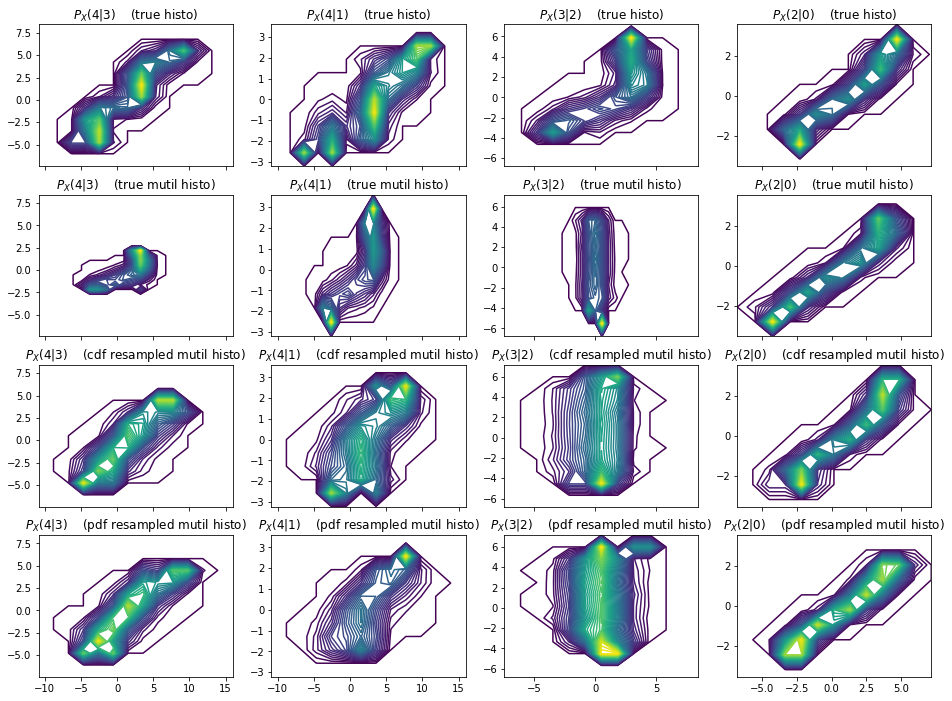

In [41]:
fig, axs = plt.subplots(4, 4, sharex='col', sharey='col', figsize = (16,12))
for col, (d,c) in col_plot_dict.items():
    axs[0][col].set_title(r'$P_X(%s|%s)$    (true histo)'%(d,c))
    axs[0][col].contour(*pX_train.get_contour_conditional(d,c), levels=50)
    axs[1][col].set_title(r'$P_X(%s|%s)$    (true mutil histo)'%(d,c))
    axs[1][col].contour(*pX_mutil.get_contour_conditional(d,c), levels=50)
    axs[2][col].set_title(r'$P_X(%s|%s)$    (cdf resampled mutil histo)'%(d,c))
    axs[2][col].contour(*pX_resampled_mutil_cdf.get_contour_conditional(d,c), levels=50)
    axs[3][col].set_title(r'$P_X(%s|%s)$    (pdf resampled mutil histo)'%(d,c))
    axs[3][col].contour(*pX_resampled_mutil_pdf.get_contour_conditional(d,c), levels=50)
    
pass;

In [42]:
def Pi_UNj_DOk(i, j, k, histogram):
    do = np.zeros(histogram.compute_joint(i, k)[1].shape)
    latent = histogram.compute_joint(j)[1]
    
    for n in range(len(latent)):
        do += histogram.compute_conditional(i,(j,k))[1][:,n,:]*latent[n]
    return do

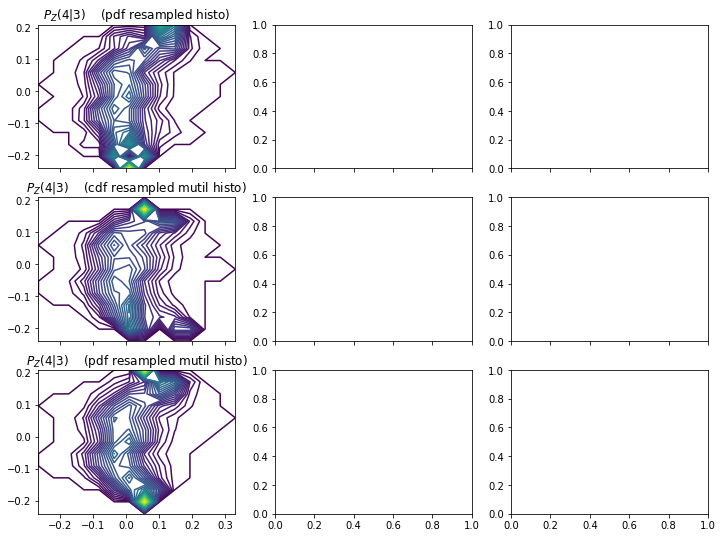

In [43]:
fig, axs = plt.subplots(3, 3, sharex='col', sharey='col', figsize = (12,9))

axs[0][0].set_title(r'$P_Z(%s|%s)$    (pdf resampled histo)'%(observe,mutilate))
axs[0][0].contour(*pZ_resampled_pdf.get_contour_conditional(observe,mutilate), levels=50)
axs[1][0].set_title(r'$P_Z(%s|%s)$    (cdf resampled mutil histo)'%(observe,mutilate))
axs[1][0].contour(*pZ_resampled_mutil_cdf.get_contour_conditional(observe,mutilate), levels=50)
axs[2][0].set_title(r'$P_Z(%s|%s)$    (pdf resampled mutil histo)'%(observe,mutilate))
axs[2][0].contour(*pZ_resampled_mutil_pdf.get_contour_conditional(observe,mutilate), levels=50)
pass;

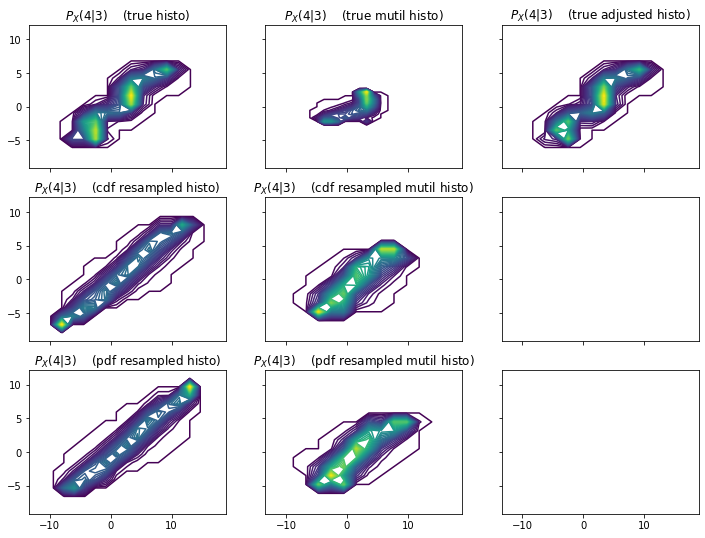

In [44]:
fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize = (12,9))
axs[0][0].set_title(r'$P_X(%s|%s)$    (true histo)'%(observe,mutilate))
axs[0][0].contour(*pX_train.get_contour_conditional(observe,mutilate), levels=50)
axs[1][0].set_title(r'$P_X(%s|%s)$    (cdf resampled histo)'%(observe,mutilate))
axs[1][0].contour(*pX_resampled_cdf.get_contour_conditional(observe,mutilate), levels=50)
axs[2][0].set_title(r'$P_X(%s|%s)$    (pdf resampled histo)'%(observe,mutilate))
axs[2][0].contour(*pX_resampled_pdf.get_contour_conditional(observe,mutilate), levels=50)

axs[0][1].set_title(r'$P_X(%s|%s)$    (true mutil histo)'%(observe,mutilate))
axs[0][1].contour(*pX_mutil.get_contour_conditional(observe,mutilate), levels=50)
axs[1][1].set_title(r'$P_X(%s|%s)$    (cdf resampled mutil histo)'%(observe,mutilate))
axs[1][1].contour(*pX_resampled_mutil_cdf.get_contour_conditional(observe,mutilate), levels=50)
axs[2][1].set_title(r'$P_X(%s|%s)$    (pdf resampled mutil histo)'%(observe,mutilate))
axs[2][1].contour(*pX_resampled_mutil_pdf.get_contour_conditional(observe,mutilate), levels=50)



axs[0][2].set_title(r'$P_X(%s|%s)$    (true adjusted histo)'%(observe,mutilate))
axs[0][2].contour(*np.meshgrid(*pX_train.node_data.axes(observe,mutilate)), 
                  Pi_UNj_DOk(observe,latent,mutilate, pX_train.histogram).T, levels=50)
pass;

In [28]:
# shd_trials

#### noise = 0.1
# [5, 5, 3, 3, 5, 3, 7, 4, 5, 6, 6, 3, 4, 3, 5, 3, 4, 6, 4, 4]
# 4.4 +- 1.2
# [5, 3, 3, 2, 5, 5, 5, 7, 4, 2, 3, 2, 4, 4, 5, 4, 3, 4, 5, 4]
# 3.95 +- 1.24

#### noise = 0.3
# [1, 2, 1, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 1, 2, 3]
# 2.05 +- 0.589

#### noise = 0.5
# [1, 1, 3, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0]
# 1.2 +- 0.60

#### noise = 0.7
# [0, 1, 0, 1, 1, 3, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1]
# 0.65 +- 0.726

In [29]:
# shd_trials
# np.mean(shd_trials)
# np.std(shd_trials)

####### node_dict = {0:[0,1], 1:[2,3,4], 2:[5,6]}
#### noise = 0.05
### h_A experiments
# [9, 9, 11, 9, 9, 10, 9, 6, 9, 7]
# 8.8 +- 1.32664991614216
### h_A_ordered experiments
# [2, 6, 7, 5, 5, 4, 6, 7, 6, 6]
# 5.4 +- 1.42828568570857

#### noise = 0.1
### h_A experiments
# [7, 8, 7, 9, 8, 8, 4, 9, 5, 8]
# 7.3 +- 1.5524174696260025
### h_A_ordered experiments
# [1, 1, 5, 4, 4, 4, 4, 5, 3, 1]
# 3.2 +- 1.5362291495737217